In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from glob import glob
import os
import sklearn.metrics
import pandas
import re

In [73]:
run = "adftld_0_0"
pattern = re.compile(r"^(unweighted|zero|exp[0-9.]+_fa)_tfphammers(_randstruct\d+)?$")
#pattern = re.compile(r"zero_.*|unweighted_.*|exp(0\.1_diff_fa|0\.2_diff_normsc|0\.2_fa|0\.1_normsc|0\.02)_tfphammers(_randstruct\d+)?$")
results = {}

In [74]:
filenames = [fn for fn in glob("results/{}_*.csv".format(run))
             if pattern.match(os.path.basename(fn)[len(run) + 1:-4])]
len(filenames)

90

In [75]:
for filename in filenames:
    df = pandas.read_csv(filename, dtype={"labels": str})
    data = []
    for fold in df.fold.unique():
        fold_df = df[df.fold == fold]
        guess_df = fold_df[fold_df.param > 0].sort_values("param")
        ground_truth = [int(c) for c in fold_df[fold_df.param == 0]["labels"].as_matrix()[0]]
        guesses = guess_df["labels"].as_matrix()
        params = guess_df["param"].as_matrix()
        narcs = guess_df[["narcs0", "narcs1"]].as_matrix()
        fold_data = {}
        for param, guess, narcs in zip(params, guesses, narcs):
            fold_data[param] = {"true_labels": ground_truth, "guesses": [int(c) for c in guess],
                                "narcs": narcs}
        data.append(fold_data)
    method, _ = os.path.splitext(filename)
    method = method.split("_", 3)[3].replace("_compact", "")
    results[method] = data

In [12]:
methods = [("unweighted_tfphammers", "k")]
method_pattern = re.compile(r"^$")
rand_method_pattern = re.compile(r"^$")

weighted_methods = sorted([m for m in results.keys() if method_pattern.match(m)])
rand_methods = [m for m in results.keys() if rand_method_pattern.match(m)]

color_cycle = cm.rainbow(linspace(0, 1, len(weighted_methods)))

methods += [(m, c) for m, c in zip(weighted_methods, color_cycle)]
if rand_methods:
    methods.append((rand_methods, (0.5, 0.5, 0.5)))
    #methods += [(m, (0.5, 0.5, 0.5)) for m in rand_methods]

In [6]:
def plot_accuracies(methods, ax):
    method_labels = []
    for method_set, arg, kwargs in methods:
        if not type(method_set) is list:
            method_set = [method_set]
        set_accuracies = []
        for method in method_set:
            experiment = results[method]
            keys = sorted(experiment[0].keys())
            accuracies = []
            for key in keys:
                guesses = concatenate([fold[key]["guesses"] for fold in experiment])
                true_labels = concatenate([fold[key]["true_labels"] for fold in experiment])
                accuracies.append(sklearn.metrics.accuracy_score(true_labels, guesses))
            set_accuracies.append(accuracies)
        ax.plot(keys, numpy.mean(set_accuracies, axis=0), color=arg, **kwargs)
        if len(method_set) > 1:
            ax.plot(keys, numpy.mean(set_accuracies, axis=0) + numpy.std(set_accuracies, axis=0), color=arg, linestyle="dashed")
            ax.plot(keys, numpy.mean(set_accuracies, axis=0) - numpy.std(set_accuracies, axis=0), color=arg, linestyle="dashed")
        method_labels.append(method_set[0])
    return method_labels

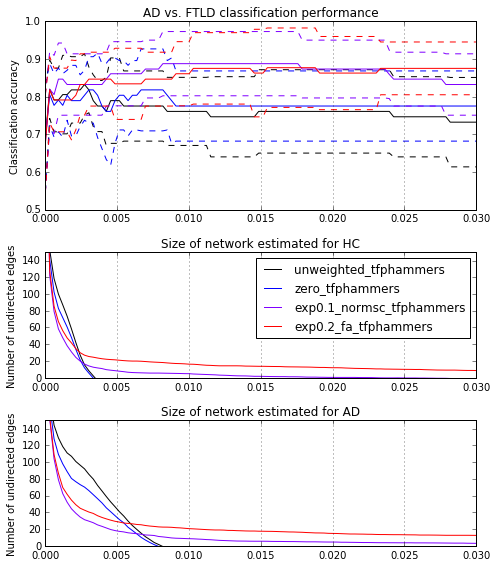

In [27]:
figsize(7, 8)
f, (a, b, c) = subplots(3, 1, gridspec_kw={"height_ratios": [3, 2, 2]})
method_labels = []

for method_set, arg in methods:
    if not type(method_set) is list:
        method_set = [method_set]
    set_accuracies = []
    for method in method_set:
        experiment = results[method]
        keys = sorted(experiment[0].keys())
        narcs = []
        accuracies = []
        std_accuracies = []
        for key in keys:
            local_accuracies = []
            for fold in experiment:
                guesses = fold[key]["guesses"]
                true_labels = fold[key]["true_labels"]
                local_accuracies.append(sklearn.metrics.accuracy_score(true_labels, guesses))
            accuracies.append(numpy.mean(local_accuracies))
            std_accuracies.append(numpy.std(local_accuracies))
            #guesses = concatenate([fold[key]["guesses"] for fold in experiment])
            #true_labels = concatenate([fold[key]["true_labels"] for fold in experiment])
            #accuracies.append(sklearn.metrics.accuracy_score(true_labels, guesses))
            narcs.append((mean([fold[key]["narcs"] for fold in experiment], axis=0) - 44) / 2)
        set_accuracies.append(accuracies)
    narcs = array(narcs).T
    a.plot(keys, numpy.mean(set_accuracies, axis=0), color=arg)
    if len(method_set) > 1:
        a.plot(keys, numpy.mean(set_accuracies, axis=0) + numpy.std(set_accuracies, axis=0), color=arg, linestyle="dashed")
        a.plot(keys, numpy.mean(set_accuracies, axis=0) - numpy.std(set_accuracies, axis=0), color=arg, linestyle="dashed")
    else:
        a.plot(keys, numpy.array(accuracies) + numpy.array(std_accuracies), color=arg, linestyle="dashed")
        a.plot(keys, numpy.array(accuracies) - numpy.array(std_accuracies), color=arg, linestyle="dashed")
    b.plot(keys, narcs[0], color=arg)
    c.plot(keys, narcs[1], color=arg)
    method_labels.append(method_set[0])

a.set_ylabel("Classification accuracy")
a.set_title("AD vs. FTLD classification performance")
a.grid(axis="x")

b.set_ylabel("Number of undirected edges")
b.set_title("Size of network estimated for HC")
b.set_ylim(0, 150)
b.legend(method_labels)
b.grid(axis="x")

c.set_ylabel("Number of undirected edges")
c.set_title("Size of network estimated for AD")
c.set_ylim(0, 150)
c.grid(axis="x")

tight_layout()

In [28]:
peak_accs = {}
for method, arg in methods:
    peak_accs[method] = []
    experiment = results[method]
    keys = sorted(experiment[0].keys())
    mean_accs = []
    for key in keys:
        guesses = concatenate([fold[key]["guesses"] for fold in experiment])
        true_labels = concatenate([fold[key]["true_labels"] for fold in experiment])
        mean_accs.append(sklearn.metrics.accuracy_score(guesses, true_labels))
    best_key = keys[numpy.argmax(mean_accs)]
    for fold in experiment:
        peak_accs[method].append(sklearn.metrics.accuracy_score(fold[best_key]["guesses"], fold[best_key]["true_labels"]))

In [29]:
peak_accs

{'exp0.1_normsc_tfphammers': [0.875,
  0.8571428571428571,
  0.7142857142857143,
  0.8571428571428571,
  1.0,
  0.8571428571428571,
  1.0,
  0.8571428571428571,
  1.0,
  0.8571428571428571],
 'exp0.2_fa_tfphammers': [0.75,
  0.8571428571428571,
  0.7142857142857143,
  0.8571428571428571,
  1.0,
  0.8571428571428571,
  1.0,
  0.8571428571428571,
  1.0,
  0.8571428571428571],
 'unweighted_tfphammers': [0.75,
  0.8571428571428571,
  0.8571428571428571,
  0.7142857142857143,
  1.0,
  0.8571428571428571,
  0.8571428571428571,
  0.8571428571428571,
  0.8571428571428571,
  0.7142857142857143],
 'zero_tfphammers': [0.75,
  0.8571428571428571,
  0.8571428571428571,
  0.7142857142857143,
  1.0,
  0.8571428571428571,
  0.8571428571428571,
  0.7142857142857143,
  0.7142857142857143,
  0.8571428571428571]}

In [13]:
import scipy.stats

In [16]:
scipy.stats.ttest_ind(peak_accs["unweighted_tfphammers"], peak_accs["exp0.1_normsc_tfphammers"])

Ttest_indResult(statistic=-1.40763748847815, pvalue=0.17627377850456913)

(0, 1.1)

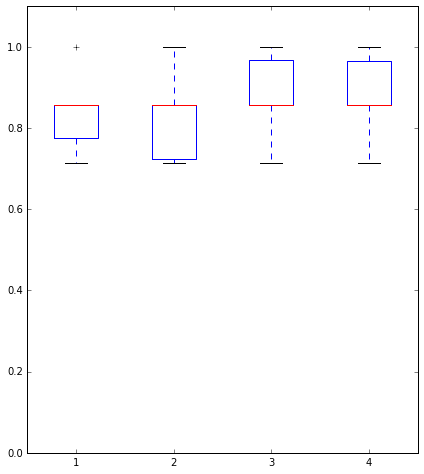

In [30]:
boxplot([peak_accs["unweighted_tfphammers"], peak_accs["zero_tfphammers"], peak_accs["exp0.1_normsc_tfphammers"],
        peak_accs["exp0.2_fa_tfphammers"]]);
ylim(0, 1.1)

In [47]:
methods = [('unweighted_tfphammers', 'k', {"lw": 1.5}),
           ('exp0.02_tfphammers', "r", {}),
           ('exp0.1_normsc_tfphammers', "b", {}),
           ('exp0.2_fa_tfphammers', "g", {}),
           ('exp0.2_diff_normsc_tfphammers', "c", {}),
           ('exp0.1_diff_fa_tfphammers', "m", {}),
]
method_names = ["no struct",
        "num tracts (σ=0.02)",
        "norm num tracts (σ=0.1)",
        "FA (σ=0.2)",
        "diff num tracts (σ=0.2)",
        "diff FA (σ=0.1)"]
filename = "../../slides/2016-07-27_final/adftld_accuracy.pdf"

In [84]:
methods = [('unweighted_tfphammers', 'k', {"ls": ":", "lw": 2}),
           ('zero_tfphammers', 'k', {}),
           ('exp0.1_normsc_tfphammers', "g", {}),
           ([m for m in results.keys() if m.startswith("exp0.1_normsc_tfphammers_randstruct")], "b", {})
]
method_names = ["no struct",
         "zero diag",
         "norm num tracts (σ=0.1)",
         "norm num tracts (σ=0.1), randomised"]
filename = "../../slides/2016-07-27_final/adftld_randstruct.pdf"

In [31]:
methods = [('unweighted_tfphammers', 'k', {}),
           ('zero_tfphammers', 'b', {}),
           ('exp0.2_fa_tfphammers', 'r', {})]
method_names = ["no struct", "zero diagonal", "exp FA (σ=0.2)"]
filename = "/tmp/adftld_zerodiag.pdf"

In [24]:
methods = [('unweighted_tfphammers_narrow', 'k', {}),
           ('zero_tfphammers_narrow', 'b', {}),
           ('exp0.2_fa_tfphammers_narrow', 'r', {})]
method_names = ["no struct", "zero diagonal", "exp FA (σ=0.2)"]
filename = "/tmp/hcad_zerodiag.pdf"

In [12]:
true_method = "exp0.2_normsc_tfphammers"
rand_methods = [s for s in results.keys() if s.startswith(true_method) and "randstruct" in s]
methods = [("unweighted_tfphammers", "k", dict()),
           ("zero_tfphammers", "b", dict()),
           (true_method, "r", dict(lw=2)),
           (rand_methods, "c", dict(lw=2))]
method_names = ["no structure", "zero diagonal", "real structure", "randomised structure"]
filename = "/tmp/adftld_rand_right.pdf"

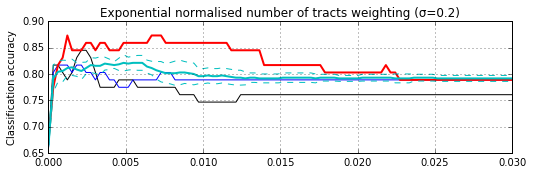

In [13]:
figure(figsize=(15*0.5, 5*0.5))
plot_accuracies(methods, gca())
#legend(method_names, ncol=2, loc="lower right")
#xlabel("Scalar regularisation parameter α")
ylabel("Classification accuracy")
ylim(0.65, 0.9)
grid()
title("Exponential normalised number of tracts weighting (σ=0.2)")
tight_layout()
if filename:
    savefig(filename)

In [40]:
all_methods = []
all_method_names = []
all_titles = []
suffix = "_narrow" if "hc" in run else ""
for scheme, scheme_name in [("", "Number of tracts"),
                            ("_normsc", "Normalised number of tracts"),
                            ("_fa", "Fractional anisotropy"),
                            ("_diff_normsc", "Difference of number of tracts"),
                            ("_diff_fa", "Difference of fractional anisotropy")]:
    for weights, weights_name in [([("unweighted", "no struct", "k"),
                                    ("pow1", "d=1", "b"),
                                    ("pow2", "d=2", "g"),
                                    ("pow3", "d=3", "r")],
                                   "power weighting"),
                                  ([("unweighted", "no struct", "k"),
                                    ("exp0.8", "σ=0.8", "c"),
                                    ("exp0.4", "σ=0.4", "y"),
                                    ("exp0.2", "σ=0.2", "seagreen"),
                                    ("exp0.1", "σ=0.1", "m"),
                                    ("exp0.05", "σ=0.05", "olive"),
                                    ("exp0.02", "σ=0.02", "brown"),
                                    ("exp0.01", "σ=0.01", "royalblue")],
                                   "exponential weighting")]:
        methods = []
        method_names = []
        for weight, weight_name, color in weights:
            if weight == "unweighted":
                methods.append(("{}_tfphammers{}".format(weight, suffix), color, {"lw": 2}))
                method_names.append(weight_name)
            else:
                methods.append(("{}{}_tfphammers{}".format(weight, scheme, suffix), color, {}))
                method_names.append(weight_name)
        all_methods.append(methods)
        all_method_names.append(method_names)
        all_titles.append("{}, {}".format(scheme_name, weights_name))
filename = "/tmp/{}_results.pdf".format(run)

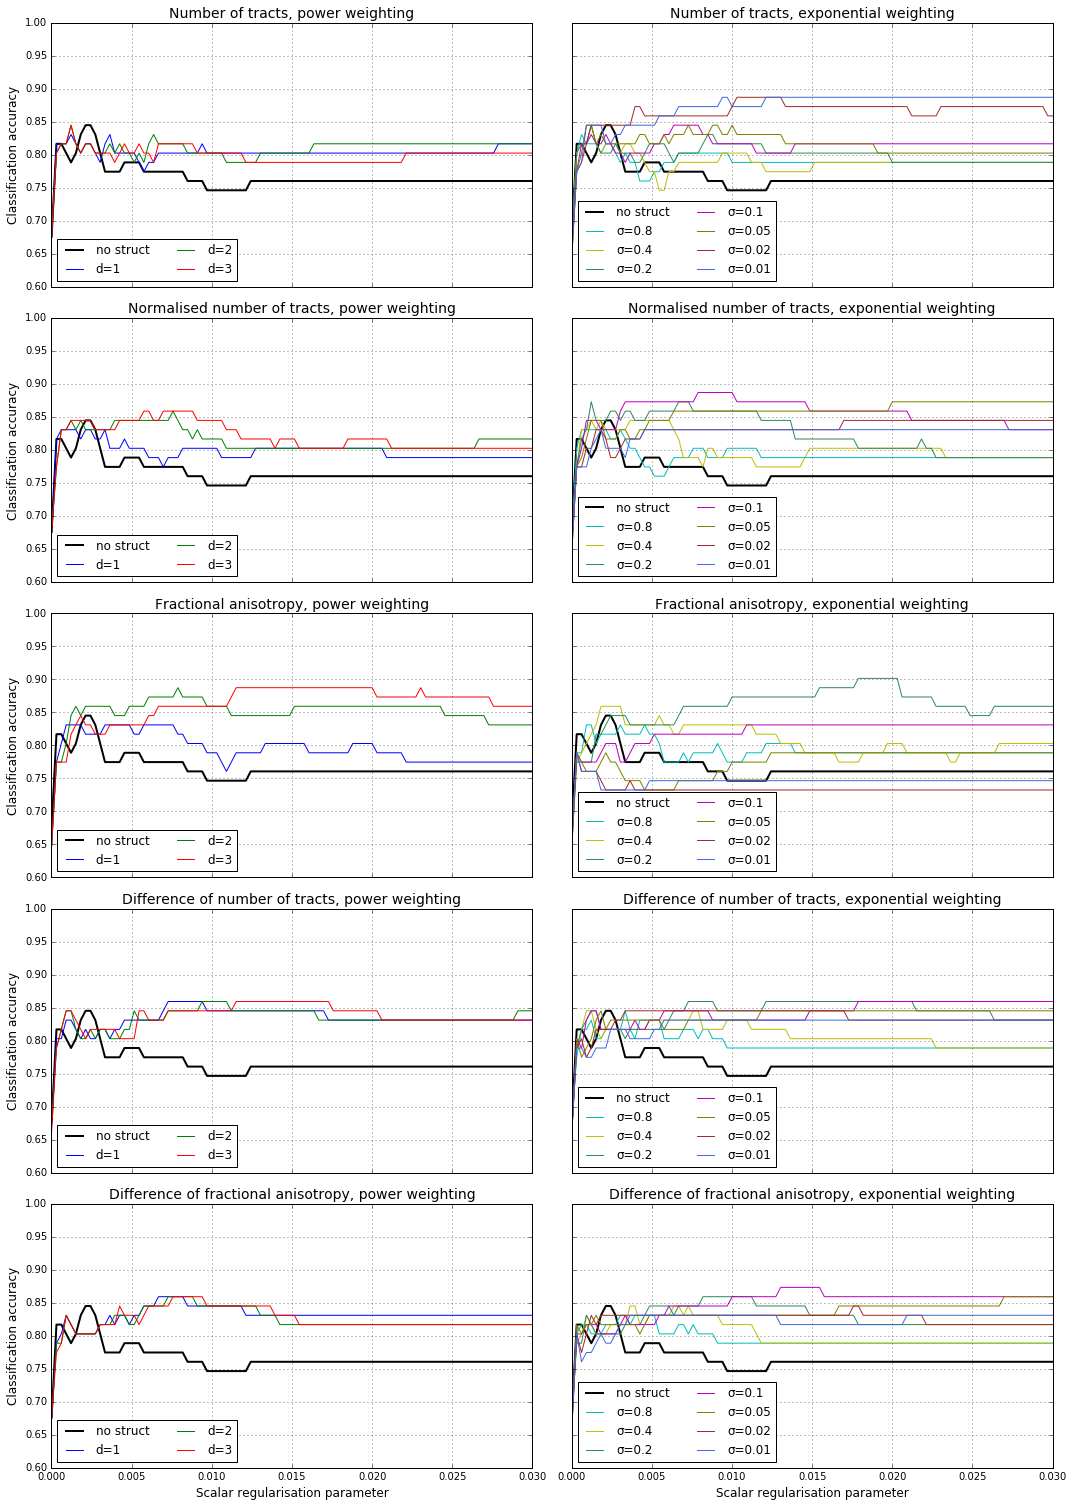

In [44]:
n_cols = 2
n_rows = (len(all_methods) + 1) // n_cols

fig = figure(figsize=(15, 21))
for i, (methods, method_names, plot_title) in enumerate(zip(all_methods, all_method_names, all_titles)):
    ax = fig.add_subplot(n_rows, n_cols, i + 1)
    if i % n_cols != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Classification accuracy", fontsize=12)
    if i < (n_rows - 1) * n_cols:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Scalar regularisation parameter", fontsize=12)
    plot_accuracies(methods, ax)
    ax.set_ylim(0.6, 1)
    ax.legend(method_names, ncol=2, loc="lower left")
    ax.set_title(plot_title, fontsize=14)
    grid()
    
tight_layout()

if filename:
    fig.savefig(filename)

In [49]:
def plot_narcs(methods, cls, ax):
    for method_set, arg, kwargs in methods:
        if not type(method_set) is list:
            method_set = [method_set]
        mean_narcs = []
        for method in method_set:
            experiment = results[method]
            keys = sorted(experiment[0].keys())
            method_narcs = []
            for key in keys:
                method_narcs.append(mean([fold[key]["narcs"] for fold in experiment], axis=0))
            mean_narcs.append(method_narcs)
        mean_narcs = array(mean_narcs)
        ax.plot(keys, numpy.mean(mean_narcs[:, :, cls], axis=0), color=arg, **kwargs)
        if len(method_set) > 1:
            ax.plot(keys, numpy.mean(mean_narcs[:, :, cls], axis=0) + numpy.std(mean_narcs[:, :, cls], axis=0), color=arg, linestyle="dashed", **kwargs)
            ax.plot(keys, numpy.mean(mean_narcs[:, :, cls], axis=0) - numpy.std(mean_narcs[:, :, cls], axis=0), color=arg, linestyle="dashed", **kwargs)

In [50]:
methods = [('unweighted_tfphammers', 'k', {"lw": 1.5}),
           ('exp0.2_normsc_tfphammers', "r", {}),
           ([s for s in results.keys() if "exp0.2_normsc" in s and "randstruct" in s], "c", {})
]
method_names = ["no struct", "norm num tracts (σ=0.2)", "rand norm num tracts (σ=0.2)"]
filename = None

In [78]:
methods = [('unweighted_tfphammers', 'k', {"lw": 1.5}),
           ('exp0.2_fa_tfphammers', "r", {}),
           ([s for s in results.keys() if "exp0.2_fa_tfphammers" in s and "randstruct" in s], "c", {})
]
method_names = ["no struct", "norm num tracts (σ=0.2)", "rand norm num tracts (σ=0.2)"]
filename = None

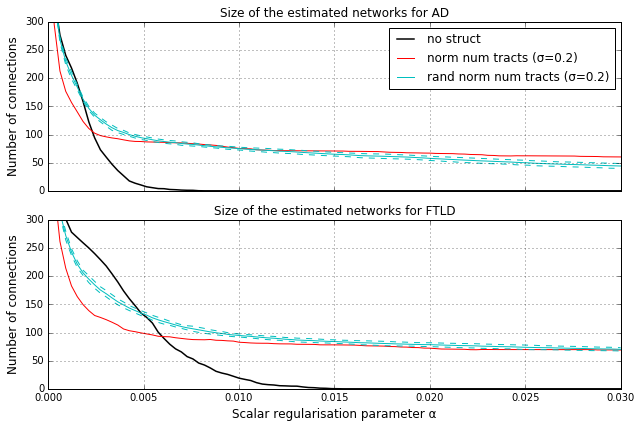

In [79]:
figure(figsize=(15*0.6, 10*0.6))
for i, cls in enumerate(["AD", "FTLD"]):
    subplot(2, 1, i + 1)
    plot_narcs(methods, i, gca())
    ylabel("Number of connections", fontsize=12)
    #xticks(linspace(0, 0.02, 11))
    if i == 0:
        legend(method_names, loc="upper right", ncol=1)
        gca().set_xticklabels([])
    else:
        xlabel("Scalar regularisation parameter α", fontsize=12)
    grid()
    title("Size of the estimated networks for {}".format(cls))
    #xlim(0, 0.02)
    ylim(0, 300)
    
tight_layout()
if filename:
    savefig(filename)

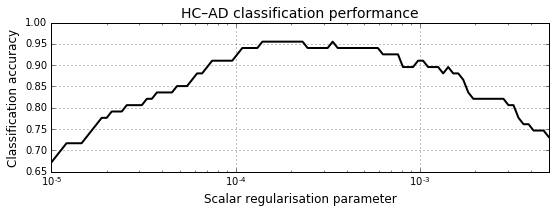

In [57]:
figure(figsize=(8, 3))
plot_accuracies([("unweighted_tfphammers_lognarrow", "k", {"lw": 2})], gca())
xlabel("Scalar regularisation parameter", fontsize=12)
ylabel("Classification accuracy", fontsize=12)
title("HC–AD classification performance", fontsize=14)
grid()
tight_layout()
semilogx()
xlim(1e-5, 5e-3)
savefig("/tmp/hcad.pdf")